# Error analysis
Let's see where the text-only model and the reader-aware models differed, and where some outperformed others.

In [15]:
import gzip
text_only_output = list(map(lambda x: x.strip(), gzip.open('../../data/reddit_data/text_only_model/test_data_sample_top_p=0.9_temperature=1.0_output_text.gz', 'rt')))
reader_token_output = list(map(lambda x: x.strip(), gzip.open('../../data/reddit_data/author_text_data/test_data_sample_top_p=0.9_temperature=1.0_output_text.gz', 'rt')))
reader_attn_output = list(map(lambda x: x.strip(), gzip.open('../../data/reddit_data/author_text_data/author_attention_data/test_data_sample_top_p=0.9_temperature=1.0_output_text.gz', 'rt')))
reader_text_embed_output = list(map(lambda x: x.strip(), gzip.open('../../data/reddit_data/author_text_data/author_text_embed_data/test_data_sample_top_p=0.9_temperature=1.0_output_text.gz', 'rt')))
reader_subreddit_embed_output = list(map(lambda x: x.strip(), gzip.open('../../data/reddit_data/author_text_data/author_subreddit_embed_data/test_data_sample_top_p=0.9_temperature=1.0_output_text.gz', 'rt')))
print(len(text_only_output))
print(len(reader_token_output))
print(len(reader_attn_output))
print(len(reader_text_embed_output))
print(len(reader_subreddit_embed_output))

59273
59273
59273
59273
59273


In [112]:
import torch
test_data = torch.load('../../data/reddit_data/combined_data_test_data.pt')
print(len(test_data))

59273


In [22]:
## combine everything lol
import pandas as pd
combined_data = pd.DataFrame([
    text_only_output,
    reader_token_output,
    reader_attn_output,
    reader_text_embed_output,
    reader_subreddit_embed_output,
    test_data['source_text'],
    test_data['target_text'],
    test_data['reader_token_str'],
    test_data['author_has_subreddit_embed'],
    test_data['author_has_text_embed'],
    test_data['article_id'],
], index=['text_only_output', 'reader_token_output', 'reader_attn_output', 'reader_text_embed_output', 'reader_subreddit_embed_output', 'source_text', 'target_text', 'reader_token', 'author_has_subreddit_embed', 'author_has_text_embed', 'article_id']).transpose()
print(combined_data.shape)
display(combined_data.head())

(59273, 11)


,text_only_output,reader_token_output,reader_attn_output,reader_text_embed_output,reader_subreddit_embed_output,source_text,target_text,reader_token,author_has_subreddit_embed,author_has_text_embed,article_id
0,Are all your fans spinning?,Are all your fans spinning?,What do you mean by this?,What are your specs?,What do you mean by this?,"Hi all,I am running a Samsung 960 Evo on my z3...",Or did you put it in the other slot?,UNK,True,True,8ilzee
1,What the hell is wrong with you people?,What the hell is wrong with you people?,What the hell is wrong with you?,Why do you want to buy a house when you have n...,Do you have any idea what kind of job you want...,I own a pub/bar one of many in this highly pop...,The fuck is wrong with you?,UNK,False,False,csdb4t
2,Does she want to be involved in your life anym...,Does she have any right to see you or your fee...,Do you have any other relatives or other famil...,How is this any of your business at all?,Do you have a job?,My mom left my dad when I was 17 (I’m 29 now) ...,Did you have play dates and supervised visits ...,UNK,False,False,bnr2gy
3,Does she work or just stay at home?,Does your wife work or just stay at home?,Why do people bother eating meat at school whe...,How long have they been together?,Do you have any idea what kind of job you want...,"Dad here, old fart, loves his daughter to piec...",Is everything in the house paid for by her?,UNK,False,False,dkqv29
4,INFO: What is your issue with not inviting his...,INFO: What is your issue with gay people?,Do you want a wedding or do you just want a ma...,What’s wrong with you?,"How are you going to pay for things like rent,...",My fiancé and I are a few months into planning...,Are your fiance's family aware that your broth...,UNK,False,False,b6yovf


In [24]:
## add subreddit data
post_data = pd.read_csv('../../data/reddit_data/subreddit_submissions_2018-01_2019-12.gz', sep='\t', compression='gzip', index_col=False, usecols=['id', 'subreddit'])
post_data.rename(columns={'id' : 'article_id'}, inplace=True)
if('subreddit' not in combined_data.columns):
    combined_data = pd.merge(combined_data, post_data, on='article_id', how='left')

Compute BLEU-1 scores for all pairs of questions and test data.

In [25]:
## TODO: tokenize lol
from tqdm import tqdm
tqdm.pandas()
from model_helpers import compute_text_bleu
from nltk.tokenize import WordPunctTokenizer
tokenizer = WordPunctTokenizer()
bleu_weights = [1.0, 0., 0., 0.]
model_output_cols = list(filter(lambda x: x.endswith('_output'), combined_data.columns))
combined_data = combined_data.assign(**{
    'target_text_tokens' : combined_data.loc[:, 'target_text'].apply(lambda x: tokenizer.tokenize(x.lower()))
})
for model_output_col in model_output_cols:
    combined_data = combined_data.assign(**{
        f'{model_output_col}_tokens' : combined_data.loc[:, model_output_col].apply(lambda x: tokenizer.tokenize(x.lower()))
    })
    combined_data = combined_data.assign(**{
        f'{model_output_col}_BLEU' : combined_data.progress_apply(lambda x: compute_text_bleu(x.loc[f'{model_output_col}_tokens'], x.loc['target_text_tokens'], weights=bleu_weights), axis=1)
    })

  0%|          | 0/59273 [00:00<?, ?it/s]/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overl

In [36]:
pd.set_option('display.max_colwidth', 1000)
model_text_1 = 'text_only_output'
model_text_2 = 'reader_token_output'
top_k = 10
for subreddit_i, data_i in combined_data.groupby('subreddit'):
    print(f'{model_text_1} vs. {model_text_2}: subreddit={subreddit_i}')
    data_i = data_i.assign(**{
        'BLEU_diff' : data_i.loc[:, f'{model_text_2}_BLEU'] - data_i.loc[:, f'{model_text_1}_BLEU']
    })
    data_i.sort_values('BLEU_diff', inplace=True, ascending=False)
    print(f'{model_text_2} > {model_text_1}')
    display(data_i.loc[:, ['source_text', 'target_text', model_text_1, f'{model_text_1}_BLEU', model_text_2, f'{model_text_2}_BLEU', 'reader_token']].head(20))
    print(f'{model_text_1} > {model_text_2}')
    data_i.sort_values('BLEU_diff', inplace=True, ascending=True)
    display(data_i.loc[:, ['source_text', 'target_text', model_text_1, f'{model_text_1}_BLEU', model_text_2, f'{model_text_2}_BLEU', 'reader_token']].head(20))

text_only_output vs. reader_token_output: subreddit=Advice
reader_token_output > text_only_output


,source_text,target_text,text_only_output,text_only_output_BLEU,reader_token_output,reader_token_output_BLEU,reader_token
41938,"Around this time of year last year, my mom and two sisters moved to texas. Long story short, the stay was progressively getting worse.We stay with our great aunt and she doesn't make things very enjoyable. Because of her attitude and the things she says to our face but how she switches over the phone, we distance ourselves from her.On monday, she sent out a text saying that there are no babies in the house and that we need to fend for ourselves. But just yesterday, she said she would punish for a month because the siblings and I are not responding to her texts where no appropriate response can be given or one isn't needed. If we aren't babies, why do you have to punish us as if we are some?Our mom is trying to work to get a place of her own, but her being a single mom and having to deal with the three of us is hard.That example up there with my aunt is just the start. There have been other things said verbally and through text. She even tried to force her religion on us at one poin...",How old are you?,Is there a trusted teacher or school counselor you can talk to?,0.080759,How old are you?,1.000000,<RESPONSE_TIME_1_AUTHOR>
54455,"I was told the house was in a different city, had more people living in it, haf ti wait over a month longer than I was told id need to to move in, and was constantoy made to feel uncomfortable by the renters flirting with me. Was the only place I could afford. Been here for two weeks and am being asked to move out at the end of the minth because they randomly decided they were going to move. Should I ask for my money back that I paid as rent at the beginning of the month or would that be too out of line?",What money did you pay?,What did they say when you told them you wanted to move out?,0.175731,What money back did you pay?,0.846482,<RESPONSE_TIME_1_AUTHOR>
18501,"she wants to be on her laptop all day playing maplestory, and i'm literally just bored on my own laptop clicking around waiting for her to uhm, idk, finish up playing? so i tell her to stop playing, i feel ignored, after 6 hours, and she says she feels really bothered that i'm still on my laptop when i told her to get off of hers. so i get off of mine and then we just sit there.?????",How old are you two?,"Did she want you to sit there for her, or did you want her to?",0.053293,"Also, how old are you?",0.705401,<RESPONSE_TIME_1_AUTHOR>
18500,"she wants to be on her laptop all day playing maplestory, and i'm literally just bored on my own laptop clicking around waiting for her to uhm, idk, finish up playing? so i tell her to stop playing, i feel ignored, after 6 hours, and she says she feels really bothered that i'm still on my laptop when i told her to get off of hers. so i get off of mine and then we just sit there.?????",How old are you two?,"Did she want you to sit there for her, or did you want her to?",0.053293,INFO: how old are you?,0.705401,<EXPERT_PCT_0_AUTHOR>
23234,"Hey,I’m in desperate need of some advice. A mouse has died in the wall of a cupboard and cannot be removed. The smell is awful and it’s very close to food products. We’ve tried using special odour neutralising sachets but they’ve done nothing and only provided another bad smell. What sort of things can we do in this situation? We keep the cupboard door open as much as we can to aerate the area but I’m concerned it’s going to take a while for the mouse to fully decompose. Would love any advice as this is a very unpleasant smell. Thanks,Kikko",Have you tried coffee grounds?,Have you tried a new cupboard that’s quieter and it doesn’t smell like anything?,0.076373,Have you tried baking soda?,0.666667,<EXPERT_PCT_1_AUTHOR>
20499,I got enough money to go on a plan with the iPhone 11 Pro. I got 696 dollars and it’s 72 dollars a month over the course of 2 years paying it off. I got a job so I can keep putting money in my account and I don’t spend m

text_only_output > reader_token_output


,source_text,target_text,text_only_output,text_only_output_BLEU,reader_token_output,reader_token_output_BLEU,reader_token
19193,"Well basically I moved to a new school in the middle of the year and I'm terrified to talk to anyone, but Im really lonely. How do I get people to like me?",What do you like?,What do you like?,1.000000,Or do you have a job where you're around other people?,0.099179,<EXPERT_PCT_0_AUTHOR>
57621,"I was laying in bed trying to fall asleep, when i thought about how people regret wasting their childhood doing stupid shit. I am currently in a pretty weird stage of life and just want to get some advice on what i should do, so that I don’t regret it in the future. I know it might sound cringe, but honestly i feel like my life doesn’t have a purpose...",How old are you?,How old are you?,1.000000,What kind of life do you want to have?,0.147152,<RESPONSE_TIME_0_AUTHOR>
19290,"Sorry this is rambly, I’m on mobile and I’m kind of just thought-vomiting.So my boyfriend (18) and I (18) have been dating just over a year now. Let me preface this by saying, I care about him a lot. He’s hands down the genuinely nicest person I know. But lately I’ve felt a little ignored, and there are some things that have bothered me for a while that are starting to be hard to ignore. He’s very immature. He has the sense of humor of a 13 hear old. He and his friend “Derek” make Youtube videos with Pokemon figures. And whenever his friends are around it’s like I’m invisible. He never invites me to hang out with him and his friends, and if I am ever in a group with him he totally ignores me. He also has really bad time management skills. He’s always, always late. We’ve missed a lot of movies and reservations in the past. He always apologizes but it never changes. And more than once he’s promised to pick me up from somewhere, and then when he’s supposed to be there to get me he’ll ...",Do you love him?,Do you still love him?,0.818731,What kind of person would be upset with you for not wanting to be around someone that is 10+ years older than you?,0.007326,<RESPONSE_TIME_1_AUTHOR>
19289,"Sorry this is rambly, I’m on mobile and I’m kind of just thought-vomiting.So my boyfriend (18) and I (18) have been dating just over a year now. Let me preface this by saying, I care about him a lot. He’s hands down the genuinely nicest person I know. But lately I’ve felt a little ignored, and there are some things that have bothered me for a while that are starting to be hard to ignore. He’s very immature. He has the sense of humor of a 13 hear old. He and his friend “Derek” make Youtube videos with Pokemon figures. And whenever his friends are around it’s like I’m invisible. He never invites me to hang out with him and his friends, and if I am ever in a group with him he totally ignores me. He also has really bad time management skills. He’s always, always late. We’ve missed a lot of movies and reservations in the past. He always apologizes but it never changes. And more than once he’s promised to pick me up from somewhere, and then when he’s supposed to be there to get me he’ll ...",Do you love him?,Do you still love him?,0.818731,What kind of person would be interested in talking to their nephew about something that happened 10+ years ago?,0.008152,<EXPERT_PCT_1_AUTHOR>
26725,"Currently I have a pretty bad trait which I am trying to overcome and change. However I'm finding it difficult to move past it. I find that if I am not instantly good at it, I lose interest very quickly or find it hard to keep that motivation going. It's really annoying because I want to learn new languages, new skills and generally just improve myself.What do you find helps overcome these issues? How do I maintain focus?",What is the trait?,What trait is it?,0.800000,Have you tried Rosetta Stone software?,0.134064,<EXPERT_PCT_0_AUTHOR>
22067,"Would it be ethical to be vegetarian in a non-vegetarian working class household. I'm a vegetarian but I can't afford to buy most of my own 

text_only_output vs. reader_token_output: subreddit=AmItheAsshole
reader_token_output > text_only_output


,source_text,target_text,text_only_output,text_only_output_BLEU,reader_token_output,reader_token_output_BLEU,reader_token
49681,"Hello again AITA, you guys have previously weighed in on the long running battle between me and my sister so I figured I'd turn to you again to see if I really messed up. I'm always on my family's bad side so I appreciated the neutral input last time.Somehow it's become a tradition in my family that one family member host a Friday night dinner once a month. Last night was my night. My oldest sister and I have not been speaking since our vacation (click on user name to see why if you're curious) and I was able to avoid her at the January and February dinner at other's houses. I really, really didn't want her in my apartment. So I decided since she hates spicy food and her kids are allegedly allergic to peanuts, I could side step the issue and make this Thai peanut noodle dish that I love. I announced it well in advance in the group email what I was planning. Well since my sister is much more diabolical than I give her credit for, she had her husband drive the 2 hours to my place, f...",What is wrong with you?,"NTA, what sort of person takes someone else's pet and wants to eat their own food?",0.032324,What is wrong with you?,1.000000,<NONUS_AUTHOR>
49682,"Hello again AITA, you guys have previously weighed in on the long running battle between me and my sister so I figured I'd turn to you again to see if I really messed up. I'm always on my family's bad side so I appreciated the neutral input last time.Somehow it's become a tradition in my family that one family member host a Friday night dinner once a month. Last night was my night. My oldest sister and I have not been speaking since our vacation (click on user name to see why if you're curious) and I was able to avoid her at the January and February dinner at other's houses. I really, really didn't want her in my apartment. So I decided since she hates spicy food and her kids are allegedly allergic to peanuts, I could side step the issue and make this Thai peanut noodle dish that I love. I announced it well in advance in the group email what I was planning. Well since my sister is much more diabolical than I give her credit for, she had her husband drive the 2 hours to my place, f...",What is wrong with you?,"NTA, what the fuck is wrong with your family that they even speak to her like that?",0.095466,What is wrong with you?,1.000000,<EXPERT_PCT_0_AUTHOR>
49683,"Hello again AITA, you guys have previously weighed in on the long running battle between me and my sister so I figured I'd turn to you again to see if I really messed up. I'm always on my family's bad side so I appreciated the neutral input last time.Somehow it's become a tradition in my family that one family member host a Friday night dinner once a month. Last night was my night. My oldest sister and I have not been speaking since our vacation (click on user name to see why if you're curious) and I was able to avoid her at the January and February dinner at other's houses. I really, really didn't want her in my apartment. So I decided since she hates spicy food and her kids are allegedly allergic to peanuts, I could side step the issue and make this Thai peanut noodle dish that I love. I announced it well in advance in the group email what I was planning. Well since my sister is much more diabolical than I give her credit for, she had her husband drive the 2 hours to my place, f...",What is wrong with you?,"NTA, what the fuck is she doing with her pearls?",0.245253,What is wrong with you?,1.000000,<RESPONSE_TIME_0_AUTHOR>
51147,"ThrowawayOkay, I have a two-month-old and am currently on paternity leave. I’m fortunate to work at a place that’s family-oriented and where I’m a senior employee. I’m able to get a longer than typical paternity leave by working remotely from home. However, I had to go into the office to get documents that could only be accessed on my work computer. I thought I woul

text_only_output > reader_token_output


,source_text,target_text,text_only_output,text_only_output_BLEU,reader_token_output,reader_token_output_BLEU,reader_token
2120,"Ever since I was young, all I could ever remember of my father was having really high expectations of me (but only with regards to things that he was interested in, like golf, physical activity and carpentry), and that he would always yell and scream at me and fight with my mother over the stupidest things.All my life I was walking on eggshells around him, because anything I said or did could be interpreted as an offence to him. Not breathe hard enough after a run? Clearly I'm doing something wrong; scream. Pick the cucumbers out of a sandwich he made for me? Clearly I'm ungrateful; scream. Adding the ingredients to soup in a different order than he showed me? Clearly I'm being defiant and disrespecting him; scream.And this wasn't even like just scream explosively for a few minutes. He would rant for fucking hours about the same stuff, twisting and warping my words and actions and never letting me get a chance to explain or defend myself. And of course, I would just stand there and...",How old are you?,How old are you?,1.000000,What's your reason for not talking to him anymore?,0.049319,UNK
58874,"Ok....so my parents are in a shitty situation. Basically my dad's a bit of a psycho and treats my mom poorly. This time however, she was the one making a mistake, even though it kinda was his fault.....i won't get into detail here. Now he acts as if he is a victim of her being psycho. He won't talk to her at all and when he does it's only to insult her, even though she said she's sorry a thousand times.Yesterday after she was done with her work shift, she called me and said that all trains are cancelled due to someone standing on the rails. She says she's going to use the tube but asks me to ask my father if he can come get her with a car from the station because it is raining heavily. I ask him, he finds a cheap excuse saying he drank a beer and can't. I ask him again saying it's raining. ""No"".So I tell her to take a cab from where she's getting off the tube and i'll come out the house and pay the ride as she didn't have any money.She wanted me to ask my father again but I knew he...",Info: how old are you?,INFO: How old are you?,1.000000,"Also, how does she have a bf if she has been depressed for a few weeks?",0.059357,<NONUS_AUTHOR>
58876,"Ok....so my parents are in a shitty situation. Basically my dad's a bit of a psycho and treats my mom poorly. This time however, she was the one making a mistake, even though it kinda was his fault.....i won't get into detail here. Now he acts as if he is a victim of her being psycho. He won't talk to her at all and when he does it's only to insult her, even though she said she's sorry a thousand times.Yesterday after she was done with her work shift, she called me and said that all trains are cancelled due to someone standing on the rails. She says she's going to use the tube but asks me to ask my father if he can come get her with a car from the station because it is raining heavily. I ask him, he finds a cheap excuse saying he drank a beer and can't. I ask him again saying it's raining. ""No"".So I tell her to take a cab from where she's getting off the tube and i'll come out the house and pay the ride as she didn't have any money.She wanted me to ask my father again but I knew he...",Info: how old are you?,INFO: How old are you?,1.000000,"Also, does she have mental illness?",0.123840,<RESPONSE_TIME_1_AUTHOR>
58875,"Ok....so my parents are in a shitty situation. Basically my dad's a bit of a psycho and treats my mom poorly. This time however, she was the one making a mistake, even though it kinda was his fault.....i won't get into detail here. Now he acts as if he is a victim of her being psycho. He won't talk to her at all and when he does it's only to insult her, even though she said she's sorry a thousand times.Yesterday after she was done with her work shift, s

text_only_output vs. reader_token_output: subreddit=legaladvice
reader_token_output > text_only_output


,source_text,target_text,text_only_output,text_only_output_BLEU,reader_token_output,reader_token_output_BLEU,reader_token
20203,"Alright Reddit, first post, long time lurker. I'll try to keep this brief, but I have a situation.Over the course of several months, occasionally I would spend the evening at this apartment complex. Now, on more than one occasion (4,to be exact) I came out in the morning to my driver door vandalized. Only the driver door, as though I was being targeted. This happened over the course of several months and got progressively worse.I got smart, and bought a dashcam, because my car is important to me, and I take enough pictures of it to have documentation of the progression of the damage over the course of that time. Well, the dumbfuck came by again, at 5am, and I got him pretty clearly on camera. (Vantrue N2 Pro, for those curious). My lady friend recognizes him as her baby daddy, and former live-in boyfriend. They have been broken up for some time, but hes still hung up on her, bringing her gifts, trying to engage in manipulative behavior, trying to get her back or control her or what...","Or is that another claim, with another $500 deductible?",You say that you’re legal in WA but would you like to sue the person if they did this?,0.072433,"Or is that claim, with another $500 deductible?",0.916667,<EXPERT_PCT_1_AUTHOR>
20204,"Alright Reddit, first post, long time lurker. I'll try to keep this brief, but I have a situation.Over the course of several months, occasionally I would spend the evening at this apartment complex. Now, on more than one occasion (4,to be exact) I came out in the morning to my driver door vandalized. Only the driver door, as though I was being targeted. This happened over the course of several months and got progressively worse.I got smart, and bought a dashcam, because my car is important to me, and I take enough pictures of it to have documentation of the progression of the damage over the course of that time. Well, the dumbfuck came by again, at 5am, and I got him pretty clearly on camera. (Vantrue N2 Pro, for those curious). My lady friend recognizes him as her baby daddy, and former live-in boyfriend. They have been broken up for some time, but hes still hung up on her, bringing her gifts, trying to engage in manipulative behavior, trying to get her back or control her or what...","Or is that another claim, with another $500 deductible?","If you do, what is the legal question here?",0.250000,"Or is that claim, with another $500 deductible?",0.916667,<RESPONSE_TIME_1_AUTHOR>
35236,"Located in IAYoungest daughter is POA for grandfather. A will from 2008 shows everything split equally between all children of his with his signature. Within the next few years he fell victim to severe dementia and no longer even knew who his family members were. The POA somehow got a lawyer to draft a new will leaving her with everything (over $1 Million in value) and the other siblings with very little. I have yet to see the actual will, but if the grandfather signed wouldn't contract law easily void the will based on the fact that he is not of sound mind? If the POA was the one who signed the document couldn't it easily be said that she wasn't handling financial transactions for the grandfather, but rather for her own personal interest and void the will?&amp;#x200B;Is there a specific type of lawyer that should be engaged?",Have you seen this new will?,Is the POA still in probate?,0.142857,Have you seen the will?,0.714286,<RESPONSE_TIME_1_AUTHOR>
35235,"Located in IAYoungest daughter is POA for grandfather. A will from 2008 shows everything split equally between all children of his with his signature. Within the next few years he fell victim to severe dementia and no longer even knew who his family members were. The POA somehow got a lawyer to draft a new will leaving her with everything (over $1 Million in value) and the other siblings with very little. I have yet to see the actual will, but if t

text_only_output > reader_token_output


,source_text,target_text,text_only_output,text_only_output_BLEU,reader_token_output,reader_token_output_BLEU,reader_token
58415,"I live in New Jersey, I’m currently 15 years old and live with my sister and abusive mother. She has driven my father out of the house and caused him to live somewhere else. This abuse and neglect has been going on for years and I, very obviously, need to leave. I turn 16 in September and would like to leave, my question is, generally, how would I go about getting emancipated successfully. What kind of questions do they ask and how could I answer these questions in the best way possible? Another concern I have is if a lawyer is worth it, and will help with my case. I would also like to start filing now since I know it takes months but do I have to wait until I’m 16 to start? Any help Is appreciated",Do you have a job?,Do you have a job?,1.000000,First question: do you have any info on what you’d need to do to get emancipated?,0.064648,<RESPONSE_TIME_1_AUTHOR>
58414,"I live in New Jersey, I’m currently 15 years old and live with my sister and abusive mother. She has driven my father out of the house and caused him to live somewhere else. This abuse and neglect has been going on for years and I, very obviously, need to leave. I turn 16 in September and would like to leave, my question is, generally, how would I go about getting emancipated successfully. What kind of questions do they ask and how could I answer these questions in the best way possible? Another concern I have is if a lawyer is worth it, and will help with my case. I would also like to start filing now since I know it takes months but do I have to wait until I’m 16 to start? Any help Is appreciated",Do you have a job?,Do you have a job?,1.000000,First question: do you have a court date already?,0.362165,<EXPERT_PCT_0_AUTHOR>
50125,"I live in the United States. I am 21 years old, and i got a letter saying that from the time i was 10-13 years old my dad overpaid in child support and that I am being held responsible for it, they are demanding $10,000 and are threatening to go into my bank account and taking the money from me. My first question is *WHAT THE FUCK*My second question is how is it legal to hold a 10-13 year old responsible for this like wtf is going on.",What are you paying?,What state are you in?,0.654985,"What's the letter or notice number, identified in the upper right corner of page one?",0.024324,<EXPERT_PCT_0_AUTHOR>
15243,"We got divorced 5 years ago. it was a ""good"" divorce. She got the house and her things i got my car and my things. it was pretty straight forward. She eventually took me to court last year because of late payments on my car, she cosigned. She took me to court for contempt because it was hurting her credit. I tried refinancing the car several times but couldn't because my name was on the house. I finally got it done. But now i want to get a house or some land to build on. I'm still on the house loan and she has re-married. What would be the best way to go about handling this? I have a good job now and get paid well but having over 100k of debt still in my name isnt going to help me at all despite her having the house and responsibility of payments. Im not sure who i need to talk to as far as what type of lawyer or anything.",Did you have a divorce attorney?,Did you have an attorney for the divorce?,0.644123,What is your income and what are your other debts?,0.080674,<RESPONSE_TIME_1_AUTHOR>
15242,"We got divorced 5 years ago. it was a ""good"" divorce. She got the house and her things i got my car and my things. it was pretty straight forward. She eventually took me to court last year because of late payments on my car, she cosigned. She took me to court for contempt because it was hurting her credit. I tried refinancing the car several times but couldn't because my name was on the house. I finally got it done. But now i want to get a house or some land to build on. I'm still on the house loan and she h

text_only_output vs. reader_token_output: subreddit=pcmasterrace
reader_token_output > text_only_output


,source_text,target_text,text_only_output,text_only_output_BLEU,reader_token_output,reader_token_output_BLEU,reader_token
37360,"Hi, recently i noticed that my pc i built a while back has been behaving in a strange way. In order of first occurrence:* Every so often it would bluescreen. (I tossed this up to windows 10 being windows 10)* I'd come home to see my pc off (presumably it BSOD'd while i was away)* Games started crashing without errors (fine one minute, on the desktop the next, no warning or stuttering)* Apps, specifically their GUI started acting weird. (chrome's top bar would go black and flicker on only one window, always and ONLY the window that was on the leftmost monitor when it started)* Weird artifacting would start on games running on my leftmost monitor. (strange green patterns flashing. went away after resizing window)* Games, specifically KSP, would crash on load, or improperly load. (certain parts were missing or had the incorrect model assigned)* I think this is either a ram thing or a gpu think. Leaning to GPU because most of the symptoms are graphics or game related, but i'm not sure....",How old is your windows installation?,Do you try turning it off and on again?,0.093063,How old is your Windows installation?,1.000000,<RESPONSE_TIME_0_AUTHOR>
26074,How long will my i5 4690 and rx570 4gb last me for gaming? Should I upgrade this year or wait it out?,What games do you play?,What is your budget and what are you trying to get it for?,0.131799,What games do you play?,1.000000,<RESPONSE_TIME_0_AUTHOR>
49234,"Having a hard time deciding on which graphics card to get for my build. Both cards are being sold locally on Kijiji, the 1070 is 350$CAD (Gigabyte Windforce OC), and the 1070ti is 450$CAD (Asus Strix). Is the Ti worth it for maybe 10-15% more power?",What is your budget?,Do you live in the US?,0.134064,What is your budget?,1.000000,<EXPERT_PCT_0_AUTHOR>
26072,How long will my i5 4690 and rx570 4gb last me for gaming? Should I upgrade this year or wait it out?,What games do you play?,What is your budget and what resolution are you playing at?,0.183940,What games do you play?,1.000000,<US_AUTHOR>
26073,How long will my i5 4690 and rx570 4gb last me for gaming? Should I upgrade this year or wait it out?,What games do you play?,What is your current GPU and ram?,0.238844,What games do you play?,1.000000,<EXPERT_PCT_0_AUTHOR>
36979,Whenever I try to record rocket league gameplay with OBS the recording comes up corrupted [(as seen in here)](https://youtu.be/Skxzisg_Tm0) .Here's my OBS [video settings](https://i.imgur.com/ZsmWS13.png),What are your hardware specs?,Is that the OBS recording or just OBS?,0.101088,What are your specs?,0.833333,<RESPONSE_TIME_1_AUTHOR>
46849,Just wondering whether I will be sacrificing performance by going with an AMD cpu over an intel one and what GPU to buy for 60+FPS on some AAA titles.... thanks heaps in advance,About what is your budget?,What games are you looking to play and at what resolution/refresh rate?,0.074377,What is your CPU?,0.666667,<RESPONSE_TIME_1_AUTHOR>
18494,"I recently added a Corsair cpu water cooler to my system but now my monitors are showing ""no signal"" in stumped. I only have 600 watts of power im guessing this could be the issue?",Is the cable plugged into the graphics card and not the motherboard?,what are the complete specs of the system?,0.230769,Is the water cooler plugged into the motherboard or the graphics card?,0.769231,<EXPERT_PCT_1_AUTHOR>
56110,"Ok so yeah might be wrong place, but r/applehelp are no help.Trying to force either boot in safe mode or boot with intel graphics on 2011 imac. For safe mode I tried 'sudo nvram something something' but not working. I can only find command line to boot with intel (not amd) graphics for macbook, which doesnt seem to work for imac.",Have you googled your question yet?,Is your computer plugged into a USB 3 port and is it connected to a USB 2.0 port?,0.038667,Have you tried updating your BIOS?,0.571429,<

text_only_output > reader_token_output


,source_text,target_text,text_only_output,text_only_output_BLEU,reader_token_output,reader_token_output_BLEU,reader_token
55115,"Hello! I'm having some trouble with dolphin. Numerous games I've tried run at around 60% so there is stuttering and messed up audio. My is a dell inspiron 7577 with a 1060, 16GB of ram and an i7 7700HQ. I turned all the NVIDIA junk off, reinstalled the most recent one, and have tried all other suggestions for settings online. Temps dont get above 60. ANy ideas?Edit I remember my computer makes other games run at 40fps but idk if it still does. They aren't choppy tho",What are your Dolphin settings?,What are your graphics settings?,0.833333,How are you setting the timings on your cpu?,0.256709,<EXPERT_PCT_0_AUTHOR>
22638,"Dear Gaming PC community,I bought a PC for Destiny 2 Shadowkeep after Cross Save and I am moving from PS4. Up to now the experience has been a nightmare, it is my first gaming PC and it supposedly has more than enough specs but I have yet to play anything.I got a free copy of Control to test it and I have not been able to make it work.First the GPU was broken and had it replaced and now the launcher and the task manager marks the game is running but it is not. I have downloaded all the drivers, re-installed the game etc. I don’t know what else I should do.ThanksPD I am old and new on this Reddit thing",What other games have you tried?,What other hardware do you have?,0.714286,"What do you mean by ""refused to make it work""?",0.139869,<RESPONSE_TIME_1_AUTHOR>
22637,"Dear Gaming PC community,I bought a PC for Destiny 2 Shadowkeep after Cross Save and I am moving from PS4. Up to now the experience has been a nightmare, it is my first gaming PC and it supposedly has more than enough specs but I have yet to play anything.I got a free copy of Control to test it and I have not been able to make it work.First the GPU was broken and had it replaced and now the launcher and the task manager marks the game is running but it is not. I have downloaded all the drivers, re-installed the game etc. I don’t know what else I should do.ThanksPD I am old and new on this Reddit thing",What other games have you tried?,What other hardware do you have?,0.714286,"What do you mean by ""refused to make it work""?",0.139869,<EXPERT_PCT_0_AUTHOR>
22341,My monitor is the BenQ XL2540 obviously at 240hz in nvidia and windows settings. I have all the recommended settings on in nvcp and on the monitor. It kinda fricken blows. It’s been 4 months and I can’t fix it. Anything helps. Please. I’m begging.,you are using a Dp right?,What resolution are you using?,0.571429,How about the gpu : is it plugged into the motherboard or the graphics card?,0.039493,<EXPERT_PCT_1_AUTHOR>
23017,"Hello everyone, and thanks in advance for any help.I've been facing this issue since I upgraded to a Ryzen 2600 System back in Oct. 2018. At the time the build was as follows:Ryzen 5 26000 (overclocked at times, but issue persists at Stock as well)Cooled by a Cryorig H7 PlusMSI B450-A Plus (latest drivers at the time)16GB G.Skill 3000MHz RAMGigabyte Gaming G1 GTX 1070 (Up-to-date drivers)Corsair TX650mMy issue is that I cannot play games that use Anti Cheat services. This goes between BattleEye and EasyAntiCheat as far as I've tested. Across Origin or Steam. Games like Rising Storm 2, Apex Legends, 7 Days to Die, PUBG, Day of Infamy. These are all games I tested. Most of these I played on my previous system without issue (i5-4460, 12GB DDR3 RAM, same GPU and storage drives)What happens is when the game loads up, I get the initial splash, and when the AntiCheat tries to load, my PC blue screens, with consistent errors always referencing the same things.&gt; On Mon 2/4/2019 10:05:49 ...",Have you tried the obvious?,Have you tried overclocking your cpu?,0.564321,"Have you checked for other issues, cpu issues, gpu issues, any issues with any other cpu issues?",0.041042,<EXPERT_PCT_0_AUTHOR>
40630,I want to upgrade my Samsung monitor C24f390 for a 

text_only_output vs. reader_token_output: subreddit=personalfinance
reader_token_output > text_only_output


,source_text,target_text,text_only_output,text_only_output_BLEU,reader_token_output,reader_token_output_BLEU,reader_token
44048,"I'm considering a fairly standard 3% balance transfer, 0% APR for 12 months, for a balance of a few thousand. I would like to avoid opening a new card account just for this purpose, but my bank card is the one with a zero balance.Is there anything specific to bank credit cards that would make this a bad idea? For example, does the bank now know I have debt and won't give me a good rate on a hypothetical future car loan? Or, is it good the bank sees me paying that balance to zero so it actually improves my standing with them? Or, is it all irrelevant?By the way, I'm in this situation because a few life emergencies hit all at once last year, draining my emergency fund and still racking up this few thousand on a credit card. So, I'll be fine thanks to all the great advice I've read here. I just have this vague memory of reading a comment warning about balance transfers to a card at my own bank. Did I imagine that?","Or, is it all irrelevant?","Or, is it good the bank sees me paying that balance to zero so it actually improves my standing with them?",0.072644,"Or, is it all irrelevant?",1.000000,<RESPONSE_TIME_0_AUTHOR>
22478,"I'm 41 years old. Finally have a stable job with stable income and benefits. I'm married with one child and we live in California. I make 170k a year and the wife make 40k. I'm just starting to put away money through my 401k employer match. I have an extra 3 grand a month. After I max out my 401k at $19,000 and an IRA Roth at $6,000. What else can I max out for our retirement? Can I open two IRAs? Do I open one for me and one for my wife? Is it a joint account? Do I make too much to max out my 401k? The 19k limit for 401k, includes my employer match correct? Does the retirement account just stop accepting contributions once I hit the 19k or do I have to be on top of it? I have no knowledge of how to do this. I don't want to make a mistake and be penalized come tax time.What would you do if you had an extra 3 grand and no retirement. Thanks so much and my apologies for the dumb questions...",Is it a joint account?,What else can I max out for our retirement?,0.085570,Is it a joint account?,1.000000,<EXPERT_PCT_0_AUTHOR>
22479,"I'm 41 years old. Finally have a stable job with stable income and benefits. I'm married with one child and we live in California. I make 170k a year and the wife make 40k. I'm just starting to put away money through my 401k employer match. I have an extra 3 grand a month. After I max out my 401k at $19,000 and an IRA Roth at $6,000. What else can I max out for our retirement? Can I open two IRAs? Do I open one for me and one for my wife? Is it a joint account? Do I make too much to max out my 401k? The 19k limit for 401k, includes my employer match correct? Does the retirement account just stop accepting contributions once I hit the 19k or do I have to be on top of it? I have no knowledge of how to do this. I don't want to make a mistake and be penalized come tax time.What would you do if you had an extra 3 grand and no retirement. Thanks so much and my apologies for the dumb questions...",Is it a joint account?,What else can I max out for our retirement?,0.085570,Is it a joint account?,1.000000,<RESPONSE_TIME_1_AUTHOR>
9008,"Hi There,I'm writing to inquire about a hypothetical situation, and I mean an actual hypothetical situation where I'm alluding to an actual situation.I currently work for a company that has a plummeting stock price. As of today it's about $2.5 a share, but I do have have about a healthy amount of them. I have to wait about 4 more years to let them vest. However, I have two main questions about them.1) If the company were to be bought out, what would happen to my stocks? How does that affect the company's stock when it is bought out? 2) It's my understanding that I'm only taxed on income generated from increased stock prices, a la capital 

text_only_output > reader_token_output


,source_text,target_text,text_only_output,text_only_output_BLEU,reader_token_output,reader_token_output_BLEU,reader_token
58325,"Long story short my father is in the ICU in critical condition. We're not sure he's going to make it. I am hoping/praying for the best, but obviously, I would like to be prepared for the worst. If that does happen, he'll be survived by my mother (however her understanding of English is very limited, so she's relying on me).Some questions I have:\-My dad did create a will, however it is based in WA state and we are all presently in FL. Is there any concern for this?\-How does debt work? If a credit card was created in my dad's name alone, are my mom and I financially responsible? Does the same extend to a mortgage or even a loan?\-What are my next steps? Do I need to hire an attorney? If so what kind? I mean literally ANY and ALL advice/information/pointers/tips/younameit would be greatly appreciated.Thanks",Does the same extend to a mortgage or even a loan?,Does the same extend to a mortgage or even a loan?,1.000000,Is there any concern for this?,0.083333,<RESPONSE_TIME_1_AUTHOR>
19584,"So I am employed by a company making good money and so is my wife and we do typical taxes every year with a W-2 and that's it (we fall into 22% federal tax bracket). However, I am also seeking to pursue a side gig to make some extra money (about 30-45 an hour), but the way the company works, I would be a contractor with them (since I filled out a W-9 when I got the job). I am also now married and will have my first child in the coming weeks.I have a few questions that I'm hoping somebody might be able to answer for me.1. What will I now classify as when doing my taxes?2. How do the various incomes (salary from employer &amp; sole proprietor income) affect my tax returns?3. I have heard that sole proprietors pay extra taxes because of self employment taxes. Will I only pay those on the side gig income and then regular taxes on my salary income?4. Related to #3, people have told me that sometimes side gigs aren't worth it because of all the extra taxes. Does my situation seem like th...",Will I only pay those on the side gig income and then regular taxes on my salary income?,Did I only pay those on the side gig income and then regular taxes on my salary income?,0.947368,Did you already itemize your deductions?,0.052632,<EXPERT_PCT_0_AUTHOR>
26745,"I just got their cashback credit card recently (Canada) with a specific limit, and also the Gold card which is a charge card and therefore no “pre-set limit”.How do I know how much I can spend ?Also **if I apply for another (new) credit card while keeping my current** cashback card, **does my limit get distributed across both?** Or do I just get extra credit ?Also does this impact credit rating or anything",Or do I just get extra credit ?,Or do I just get extra credit?,1.000000,"What does ""pre-set"" mean?",0.110312,<RESPONSE_TIME_1_AUTHOR>
26744,"I just got their cashback credit card recently (Canada) with a specific limit, and also the Gold card which is a charge card and therefore no “pre-set limit”.How do I know how much I can spend ?Also **if I apply for another (new) credit card while keeping my current** cashback card, **does my limit get distributed across both?** Or do I just get extra credit ?Also does this impact credit rating or anything",Or do I just get extra credit ?,Or do I just get extra credit?,1.000000,What is the statement balance on the card?,0.110312,<EXPERT_PCT_1_AUTHOR>
20315,"Using a throwaway account because I royally messed up and am honestly incredibly embarrassed with myself.I am in serious need of help with the state of my traditional IRA and don’t know what to do and honestly don’t really understand things and am freaking out. Basically, I switched jobs in 2015 and decided to roll over my 401k into an IRA. I had contributed only Roth contributions to the 401k, but from my understanding at the time, my Roth 401k contributions could be rolled over 

Cases where `reader_token` model outperforms `text_only` model:
- `r/Advice`
    1. 
        - `post`: "Over the past week I’ve realized that I’m not interested in the majority of jobs that require a high school degree or more."
        - `target`: "What do you want to do?"
        - `text_only_output`: "Is there any way you could minor in computer science or software engineering at all?"
        - `reader_token_output` : "What do you want to do with your life?"
        - `reader_group` : `<RESPONSE_TIME_1_AUTHOR>`
- `r/AmITheAsshole`
    1. 
        - `post`: "A few months ago I made the decision that I am atheist. I have very Christian parents and I know they likely would be angry."
        - `target`: "Why do you need to tell them at all?"
        - `text_only_output`: "Are you an asshole for telling them?"
        - `reader_token_output` : "Why do you need to tell them at all?"
        - `reader_group` : `<EXPERT_PCT_0_AUTHOR>`
- `r/LegalAdvice`
    1. 
        - `post`: "Youngest daughter is POA for grandfather. A will from 2008 shows everything split equally between all children of his with his signature."
        - `target`: "Have you seen this new will?"
        - `text_only_output`: "Is the POA still in probate?"
        - `reader_token_output` : "Have you seen the will?"
        - `reader_group`: `<EXPERT_PCT_1_AUTHOR>`
- `r/PCMasterRace`
    1. 
        - `post`: "Hi, recently i noticed that my pc i built a while back has been behaving in a strange way. In order of first occurrence:* Every so often it would bluescreen. (I tossed this up to windows 10 being windows 10)* I'd come home to see my pc off (presumably it BSOD'd while i was away)* Games started c..."
        - `target`: "How old is your windows installation?"
        - `text_only_output`: "Do you try turning it off and on again?"
        - `reader_token_output` : "How old is your Windows installation?"
        - `reader_group`: `<RESPONSE_TIME_0_AUTHOR>`
- `r/PersonalFinance`
    1. 
        - `post`: "This may not be the proper forum to pose this question, but my wife needs around 20,000$ US in dental surgery."
        - `target`: "Do you have insurance?"
        - `text_only_output`: "Is there a government program or something that we can apply to?"
        - `reader_token_output` : "Do you have dental insurance?"
        - `reader_group`: `<NONUS_AUTHOR>`

Cases where `text_only` model outperforms `reader_token` model:

- `r/Advice`
    1. 
        - `post`: "Currently I have a pretty bad trait which I am trying to overcome and change. However I'm finding it difficult to move past it"
        - `target`: "What is the trait?"
        - `text_only_output`: "What trait is it?"
        - `reader_token_output` : "Have you tried Rosetta Stone software?"
        - `reader_group` : `<EXPERT_PCT_0_AUTHOR>`
- `r/AmITheAsshole`
    1. 
        - `post`: "I and my husband have been married for 7 years. We have 3 kids and I take care of them."
        - `target`: "How old are your kids?"
        - `text_only_output`: "How old are the kids?"
        - `reader_token_output` : "How much sleep does he get at night?"
        - `reader_group` : `<RESPONSE_TIME_0_AUTHOR>`
- `r/LegalAdvice`
    1. 
        - `post`: "We got divorced 5 years ago. it was a "good" divorce. She got the house and her things i got my car and my things."
        - `target`: "Did you have a divorce attorney?"
        - `text_only_output`: "Did you have an attorney for the divorce?"
        - `reader_token_output` : "What are the interest rates on the car loan?"
        - `reader_group`: `<EXPERT_PCT_0_AUTHOR>`
- `r/PCMasterRace`
    1. 
        - `post`: "I want to upgrade my Samsung monitor C24f390 for a bigger monitor with better refresh frecuency."
        - `target`: "What country, and what's your budget?"
        - `text_only_output`: "What's your budget for a new monitor?"
        - `reader_token_output` : "Is the graphic card really that big of an issue?"
        - `reader_group`: `<RESPONSE_TIME_1_AUTHOR>`
- `r/PersonalFinance`
    1. 
        - `post`: "Hi!23 years old hereSalary:100k (possibly more depending on how much OT I wanna work)"
        - `target`: "Are these taxes just accounted for every year?"
        - `text_only_output`: "Do these taxes just accounted for every year?"
        - `reader_token_output` : "How much do you make per year?"
        - `reader_group`: `<EXPERT_PCT_1_AUTHOR>`

### Compare questions: length
Do some models do better with longer/shorter questions?

In [38]:
combined_data = combined_data.assign(**{
    'target_text_len' : combined_data.loc[:, 'target_text_tokens'].apply(lambda x: len(x))
})

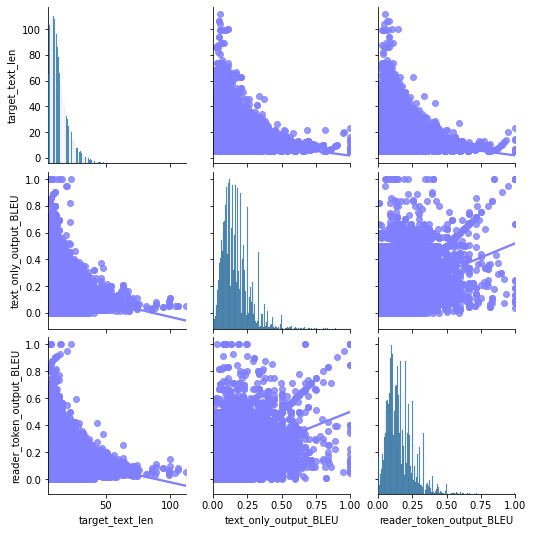

In [77]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.pairplot(data=combined_data, vars=['target_text_len', 'text_only_output_BLEU', 'reader_token_output_BLEU'], kind='reg', plot_kws={'color' : (0.5, 0.5, 1.0, 0.25)})
plt.show()

Is there any consistent difference in the correlation between question length and model performance?

In [65]:
from scipy.stats import spearmanr, pearsonr
output_vars = ['text_only_output', 'reader_token_output', 'reader_attn_output', 'reader_text_embed_output', 'reader_subreddit_embed_output']
for output_var in output_vars:
    print(f'testing output = {output_var}')
    correl, p_val = spearmanr(combined_data.loc[:, 'target_text_len'].values, 
                              combined_data.loc[:, f'{output_var}_BLEU'].values)
    print(f'correl = {correl}, p={p_val}')

testing output = text_only_output
correl = -0.09486786266187161, p=1.5119364239892349e-118
testing output = reader_token_output
correl = -0.0871170205673492, p=3.331188496362848e-100
testing output = reader_attn_output
correl = -0.17248872263964374, p=0.0
testing output = reader_text_embed_output
correl = -0.13497542807152724, p=5.527655583729402e-239
testing output = reader_subreddit_embed_output
correl = -0.13836684375867003, p=3.7448464553489195e-251


In general, all models do worse on longer text. The correlation is less severe for the `reader_token` model than for others.

### Compare questions: type
Do some models do better with different types of questions (e.g. `how` vs. `why`)?

We need a good way to extract the question word from the subject position, so let's try parsing.

In [156]:
## get children of root word C
## check for valid relations: advmod, dobj, attr
## if none, check for determiners on NPs ("which one"): det, advmod
def get_question_modifiers(parser, sentence, question_words, 
                       question_word_deps={'advmod', 'dobj', 'attr', 'aux'}, determiner_deps={'det', 'advmod'},
                       determiner_attach_deps={'acomp', 'dobj', 'attr'}):
    sentence_parse = parser(sentence)
    sentence_root = list(sentence_parse.sents)[0].root
    root_children = list(sentence_root.children)
    # check for question words in immediate children
    modifier_children = list(filter(lambda x: x.dep_ in question_word_deps, root_children))
    question_modifiers = list(filter(lambda x: x.text.lower() in question_words, modifier_children))
    # check for question words in determiners on children
    if(len(question_modifiers) == 0):
        potential_det_parents = list(filter(lambda x: x.dep_ in determiner_attach_deps, root_children))
        det_children = [y for x in potential_det_parents for y in x.children if y.dep_ in determiner_deps]
        question_det_modifiers = list(filter(lambda x: x.text.lower() in question_words, det_children))
        question_modifiers += question_det_modifiers
    # lower-case everything
    question_modifiers = list(map(lambda x: x.text.lower(), question_modifiers))
    return question_modifiers

In [158]:
import spacy
test_sents = ['How many are there?', 'What is the problem?', 'You are going where?', 'And when are you leaving?']
parser = spacy.load('en_core_web_sm')
question_words = {'how', 'when', 'where', 'what', 'who', 'why', 'which', 'do', 'should', 'could', 'would', 'can'}
for sentence in test_sents:
    sentence_parse = parser(sentence)
    sentence_question_modifiers = get_question_modifiers(parser, sentence, question_words)
    print(sentence_question_modifiers)

['how']
['what']
['where']
['when']


In [164]:
from tqdm import tqdm
tqdm.pandas()
combined_data = combined_data.assign(**{
    'question_word' : combined_data.loc[:, 'target_text'].progress_apply(lambda x: get_question_modifiers(parser, x, question_words))
})
combined_data = combined_data.assign(**{
    'question_word' : combined_data.loc[:, 'question_word'].progress_apply(lambda x: x[0] if len(x) > 0 else 'other')
})
# get word counts
question_word_counts = combined_data.loc[:, 'question_word'].value_counts()
print(question_word_counts)

other     36820
do         6796
what       4823
how        3688
why        2540
would      1625
can        1338
could       550
where       492
should      292
when        256
who          28
which        25
Name: question_word, dtype: int64


Let's see how the different models do on different questions!!

In [165]:
flat_data = pd.melt(combined_data, value_vars=['text_only_output_BLEU', 'reader_token_output_BLEU', 'reader_attn_output_BLEU', 'reader_text_embed_output_BLEU', 'reader_subreddit_embed_output_BLEU'], id_vars=['question_word'], var_name='model_type', value_name='BLEU')
display(flat_data.head())

,question_word,model_type,BLEU
0,other,text_only_output_BLEU,0.100000
1,other,text_only_output_BLEU,0.644123
2,other,text_only_output_BLEU,0.238095
3,other,text_only_output_BLEU,0.100000
4,other,text_only_output_BLEU,0.230769


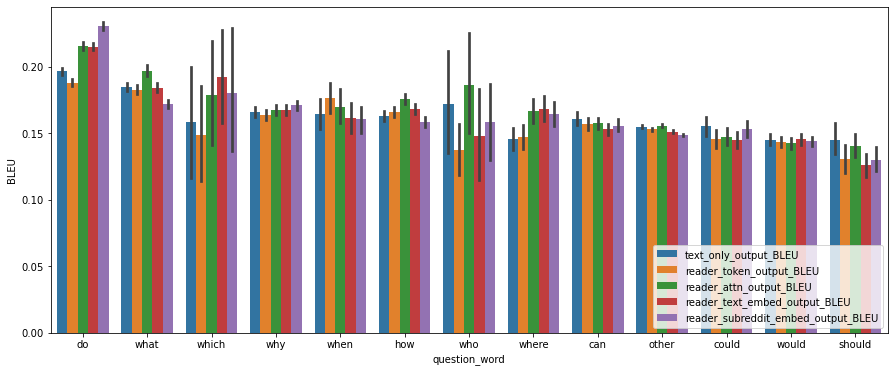

In [169]:
plt.figure(figsize=(15, 6))
sns.barplot(data=flat_data, x='question_word', y='BLEU', hue='model_type', order=sorted(flat_data.loc[:, 'question_word'].unique(), key=lambda x: flat_data[flat_data.loc[:, 'question_word']==x].loc[:, 'BLEU'].mean(), reverse=True))
plt.legend(loc='lower right')
plt.show()

- All models do well on `do`, `what` questions and poorly on `would`, `should`.
- `text_only` model does better on `could`, `can`, `should` questions.
- `reader_token` model does slighlty better `when` questions.
- `reader_attn_output` model does better on `what`, `where`, `who`, and `how` questions.
- `reader_text_embed` and `reader_subreddit_embed` models do (slightly) better on `do` and `where` questions.

### Post overlap
How much do the questions overlap with the post content?

We can measure this with two metrics:
1. max semantic overlap: find sentence with highest similarity (in sentence embedding) to question
2. topic overlap: compute topic distribution over all posts, compute overall topical alignment with post/question